# Queston 01

In [2]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Load the image in grayscale
img = Image.open('emma.jpg').convert("L")
input_pixels = np.array(img)

In [16]:
transformed_pixels = np.zeros_like(input_pixels, dtype=np.uint8)

In [20]:
# Input intensity between 0 and 49
mask_low_range = input_pixels < 50
transformed_pixels[mask_low_range] = input_pixels[mask_low_range]

In [21]:
# Input intensity between 50 and 149
mask_mid_range = (input_pixels >= 50) & (input_pixels < 150)
transformed_pixels[mask_mid_range] = (
    100 + (input_pixels[mask_mid_range] - 50) * (155 // 100)
)

In [22]:
# Input intensity between 150 and 255
mask_high_range = input_pixels >= 150
transformed_pixels[mask_high_range] = input_pixels[mask_high_range]

In [28]:
transformed_image = Image.fromarray(transformed_pixels)

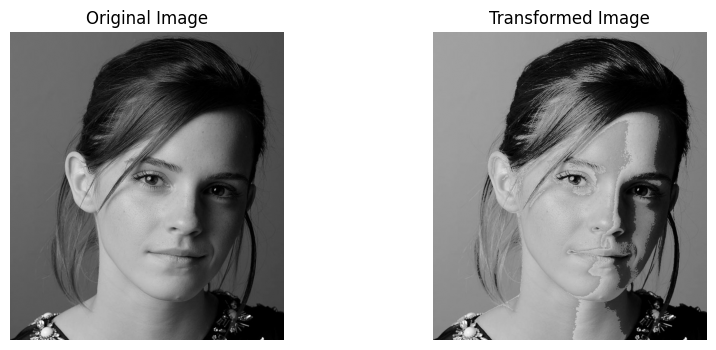

In [26]:
# Display original and transformed images side by side
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_pixels, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_pixels, cmap="gray")
plt.title("Transformed Image")
plt.axis("off")

plt.show()

# Question 02

In [30]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# ---- Helper functions ----
def estimate_non_background_percentiles(image_uint8, background_limit=5):
    all_pixels = image_uint8.ravel()
    non_background = all_pixels[all_pixels > background_limit]
    return np.percentile(non_background, [10, 35, 50, 60, 80, 90])


def build_window_lut(window_start, window_end,
                     output_min=0, output_max=255,
                     outside_slope_fraction=0.05):
    x = np.arange(256, dtype=np.float32)
    inside_slope = (output_max - output_min) / max(window_end - window_start, 1e-6)
    outside_slope = outside_slope_fraction * inside_slope

    lut = np.zeros_like(x)
    below = x < window_start
    inside = (x >= window_start) & (x <= window_end)
    above = x > window_end

    lut[below]  = output_min + outside_slope * (x[below] - window_start)
    lut[inside] = output_min + inside_slope   * (x[inside] - window_start)
    lut[above]  = output_max + outside_slope * (x[above] - window_end)

    return np.clip(lut, 0, 255).astype(np.uint8)


def apply_lookup_table(image_uint8, lut):
    return lut[image_uint8]

In [42]:
# ---- 1) Load the new clean image ----
image_path = "brain_proton_density_slice.png"
brain_image = Image.open(image_path).convert("L")
brain_pixels = np.array(brain_image)


# ---- 2) Estimate intensity ranges ----
p10, p35, p50, p60, p80, p90 = estimate_non_background_percentiles(brain_pixels)

# White matter = darker band, Gray matter = brighter band
white_matter_window = (int(p35), int(p60))
gray_matter_window  = (int(p60), int(p80))


# ---- 3) Build transforms ----
white_matter_lut = build_window_lut(*white_matter_window)
gray_matter_lut  = build_window_lut(*gray_matter_window)


# ---- 4) Apply transforms ----
white_matter_enhanced = apply_lookup_table(brain_pixels, white_matter_lut)
gray_matter_enhanced  = apply_lookup_table(brain_pixels, gray_matter_lut)

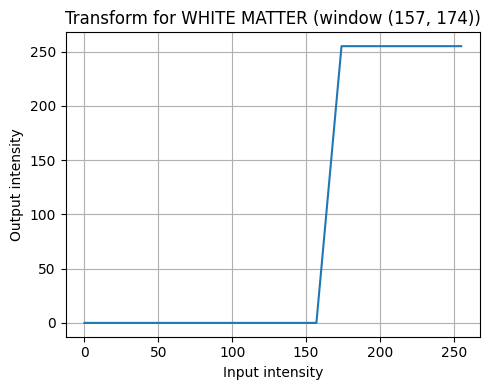

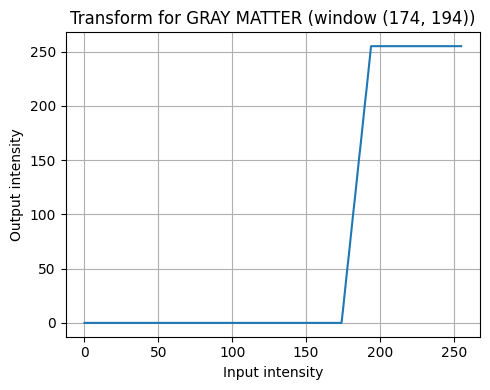

In [44]:
# ---- 5) Plot the transform curves ----
x = np.arange(256)
plt.figure(figsize=(5,4))
plt.plot(x, white_matter_lut)
plt.title(f"Transform for WHITE MATTER (window {white_matter_window})")
plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True)
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(x, gray_matter_lut)
plt.title(f"Transform for GRAY MATTER (window {gray_matter_window})")
plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True)
plt.tight_layout(); plt.show()

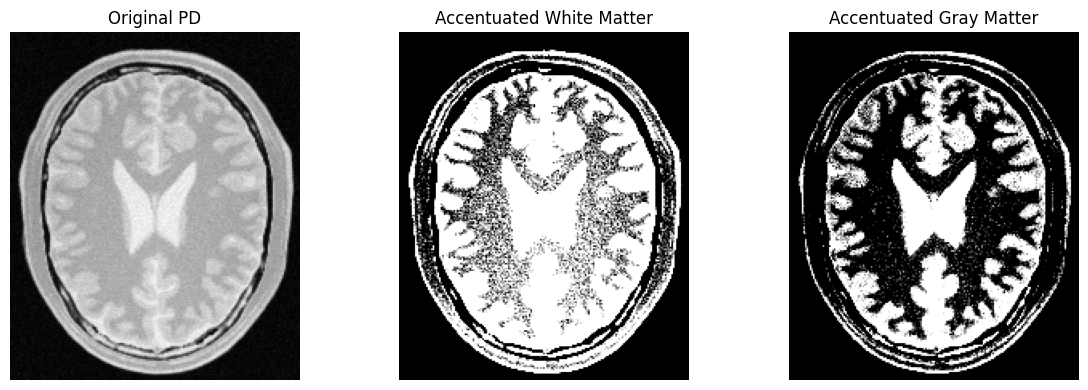

In [45]:
# ---- 6) Show the images ----
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(brain_pixels, cmap="gray"); plt.title("Original PD"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(white_matter_enhanced, cmap="gray"); plt.title("Accentuated White Matter"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gray_matter_enhanced,  cmap="gray"); plt.title("Accentuated Gray Matter");  plt.axis("off")
plt.tight_layout(); plt.show()